In [1]:
%run ../0-utils/0-Base.ipynb

Read data that will be used for training / testing:

In [12]:
%%time

feature_matrix_dfs = dict()

for feature_matrix_clazz in ("train", "test"):
    feature_matrix_df = pd.read_csv(f"../data/2-feature-engineered/{feature_matrix_clazz}.csv")
    feature_matrix_df = feature_matrix_df.drop("MODE(transactions.merchant_id)", axis=1)
    feature_matrix_df = feature_matrix_df.set_index("card_id")
    
    with pd.option_context("display.max_rows", 6):
        display(feature_matrix_df)

    feature_matrix_dfs[feature_matrix_clazz] = feature_matrix_df

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.installments),SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.installments),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.installments),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.installments),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.installments),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.installments),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE installments = -1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE installments = 999),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE category_3_1 = 1),COUNT(transactions WHERE category_2_5 = 1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_002780b4cf,2.322680,0,1,0,0,0,1,0,0,2,1,0,117,-95,-5.022747,708,3.076079,1.528783,1.731164,0.317221,10,0,6.228790,14,2.191827,-0.226015,3.023871,2.546153,-1,-4,-0.740897,13,2.166667,-1.759259,-0.093014,13.111111,54,0.851852,0.462963,0.037037,0.0,0.0000,0.000000,0.500000,0.462963,0.018519,0.777778,0.185185,0.018519,6,16,20,4,10,3,4,-1,839,5,29,5,1,1,2017,8,1,0.0,0.0,25.0,1.0,1.0,46,0.0,1.0,2.0,0.0,10.0,25.0,42.0,27.0,22,1,5,7,26,2017,12,5
C_ID_0046444c16,0.064002,0,1,0,0,0,0,1,0,2,2,0,3,-1858,-252.826756,4041,0.090782,4.093653,0.027972,0.369862,1,0,-0.430600,12,10.893001,-0.453814,4.372036,1.832516,0,-13,-0.739395,11,0.008287,-5.132597,-0.698416,11.162983,362,0.883978,0.000000,1.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.991713,0.008287,0.000000,0.000000,2,9,22,1,6,1,2,291,80,9,37,1,0,1,2016,6,2,0.0,0.0,0.0,0.0,359.0,320,0.0,0.0,362.0,0.0,0.0,0.0,3.0,0.0,31,2,12,7,11,2017,2,3
C_ID_004e76abd1,-0.707642,0,0,1,0,0,1,0,0,3,1,1,23,-30,4.593034,57,4.193249,3.109126,0.858333,0.500000,12,-3,2.407157,15,1.922522,

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.installments),SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.installments),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.installments),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.installments),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.installments),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.installments),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE installments = -1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE installments = 999),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE category_3_1 = 1),COUNT(transactions WHERE category_2_5 = 1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_0079d1f5ee,0,0,0,1,0,0,0,1,0,3,2,1,1,-764,-79.298073,1377,0.090167,4.045341,0.232648,0.397915,1,0,1.054771,12,11.090537,-0.189644,6.592414,1.557705,0,-13,-0.737141,11,0.00813,-6.211382,-0.644700,11.195122,123,0.934959,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.99187,0.00813,0.0,0.0,5,29,47,2,14,1,2,341,367,15,16,1,0,1,2016,11,1,0.0,0.0,0.0,0.0,122.0,115,0.0,0.0,123.0,0.0,0.0,0.0,1.0,0.0,27,2,12,7,6,2017,6,1
C_ID_00d20cfaa6,0,0,0,0,0,1,1,0,0,5,1,1,126,-824,-63.706384,1406,0.000000,4.064777,0.372997,0.366883,1,0,1.215359,12,0.000000,0.119300,2.920736,1.890380,1,-13,-0.746156,11,1.00000,-6.539683,-0.505606,11.158730,126,0.992063,0.039683,0.936508,0.0,0.000000,0.0,0.023810,0.039683,0.00000,1.00000,0.0,0.0,12,29,70,4,17,3,1,69,307,9,19,1,1,1,2016,9,3,0.0,0.0,5.0,0.0,0.0,125,0.0,0.0,118.0,0.0,0.0,5.0,126.0,3.0,25,2,12,7,10,2017,4,6
C_ID_023ee72d50,0,0,0,1,0,0,0,1,0,3,2,1,0,-271,-57.028197,933,0.000000,2.815828,0.055686,0.430268,0,0,-0.407309,12,0.000000,-0.618730,2.197504,1.233798,0,-9,-0.743151,11,0.

CPU times: user 2.92 s, sys: 228 ms, total: 3.15 s
Wall time: 3.15 s


Check for missing values:

In [14]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    print(feature_matrix_clazz.upper() + ":")
    
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    display(cols_with_nulls)

TRAIN:


['SKEW(transactions.installments)',
 'SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)']

TEST:


['SKEW(transactions.installments)',
 'SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)']

Get rid of missing values:

In [15]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    for skew_col in filter(lambda x: x.startswith("SKEW"), cols_with_nulls):
        feature_matrix_df[skew_col].fillna(feature_matrix_df[skew_col].mode()[0], inplace=True)
    
    print(f"{feature_matrix_clazz.upper()} has {feature_matrix_df.isnull().sum().sum()} missing values!")

TRAIN has 0 missing values!
TEST has 0 missing values!


In [31]:
X_train, y_train = feature_matrix_dfs["train"].drop("target", axis=1), feature_matrix_dfs["train"].target

X_test = feature_matrix_dfs["test"].drop("target", axis=1)

In [47]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, max_features="log2", max_depth=10, n_jobs=-1, random_state=13)
scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3))
print("CV: %.4f +/- %.4f" % (scores.mean(), scores.std() ** 2))

CV: 3.7463 +/- 0.0021
CPU times: user 6.7 s, sys: 321 ms, total: 7.02 s
Wall time: 26.5 s


In [23]:
%%time

model.fit(X_train, y_train)

CPU times: user 55 s, sys: 78.7 ms, total: 55.1 s
Wall time: 7.23 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

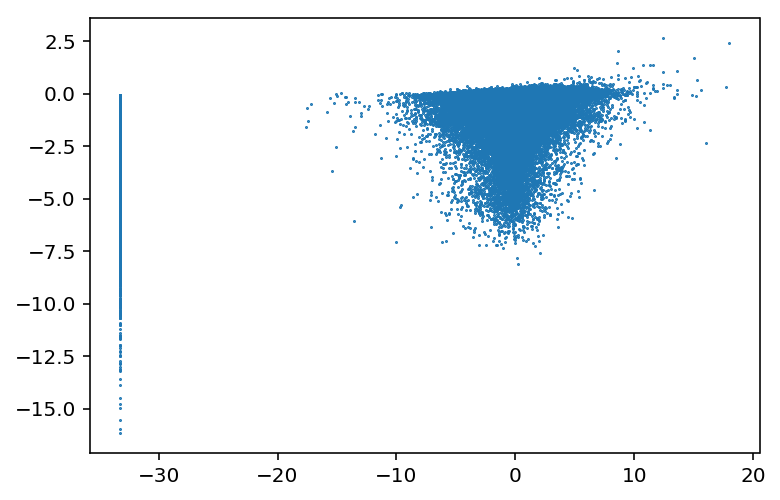

In [24]:
plt.scatter(y_train, model.predict(X_train), s=0.25);

In [32]:
%%time

y_test = model.predict(X_test)

CPU times: user 1.58 s, sys: 27.9 ms, total: 1.61 s
Wall time: 354 ms


In [45]:
submission_df = feature_matrix_dfs["test"].assign(target=y_test).loc[:, ["target"]]

with pd.option_context("display.max_rows", 6): display(submission_df)
    
submission_df.to_csv("../submission.csv")

,target
card_id,
C_ID_0079d1f5ee,-0.111458
C_ID_00d20cfaa6,-0.143064
C_ID_023ee72d50,-0.078821
...,...
C_ID_fe91e3fc9f,-0.046344
C_ID_ff02b057f5,-0.005350
C_ID_ffbb1f9527,-0.017651
